## Project specification

- **First part of the project**

Implement a standard echo state network (ESN) model. Implement training of the ESN read-out weights by means of the regularized least-square method. Perform some simulations by considering a _k_ step ahead forecasting task (evaluate several values of *k*, the forecasting horizon) on the "2sine" and "lorentz" time series and comments on the experimental results. Note that, in order to train ESNs, you will have to create a dataset of input-output pairs starting from the raw time series. Assume outputs to be unidimensional; on the other hand, you may choose the dimension of inputs, i.e. inputs to the ESN can be multidimensional. Fine tune all relevant hyper-parameters that significantly affect the model performance and provide comments on their setting.
    
- **Second part of the project**

Reconstruct and visualize the Lorentz attractor by using states of the ESN implemented in the first part of the project. Feed the implemented ESN model with the time series data in the "lorentz" file and analyze the related sequence of states generated by the ESN model. In order to visualize the *attractor* learned by the ESN, you will have to implement Principal Component Analysis (PCA) by using only numpy functions. Please **do not** use any external PCA implementations, such as the one in scikit-learn. **You may consider a PCA implementation from external libraries (e.g. scikit-learn) only for validating your own implementation of PCA**.
You will notice that the shape of the reconstructed attractor will change depending on (1) the specific setting of the (relevant) ESN hyper-parameters and (2) the number of neurons in the recurrent layer. You will have to find an hyper-parameter setting and ESN model setup that give a *good* reconstruction. Moreover, you will have to comment on whether such a reconstruction is stable under small perturbations of the hyper-parameters and random initialization of the developed ESN model.
A *good* reconstruction of the Lorentz attractor should look approximately like the one in the following figure:

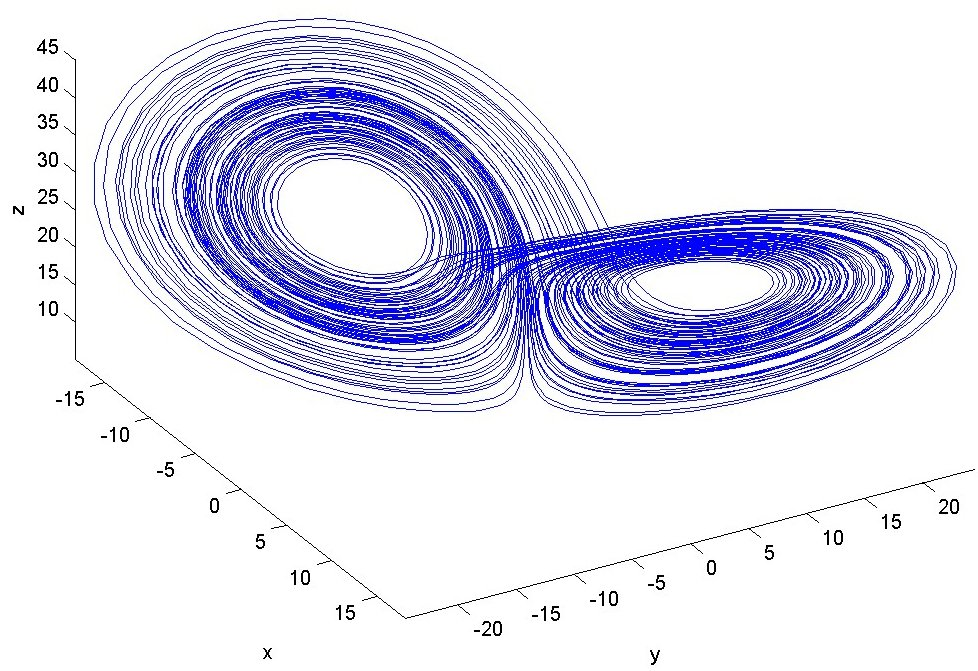

What you will obtain is most likely a somewhat distorted version of it, like shown in the following figure:
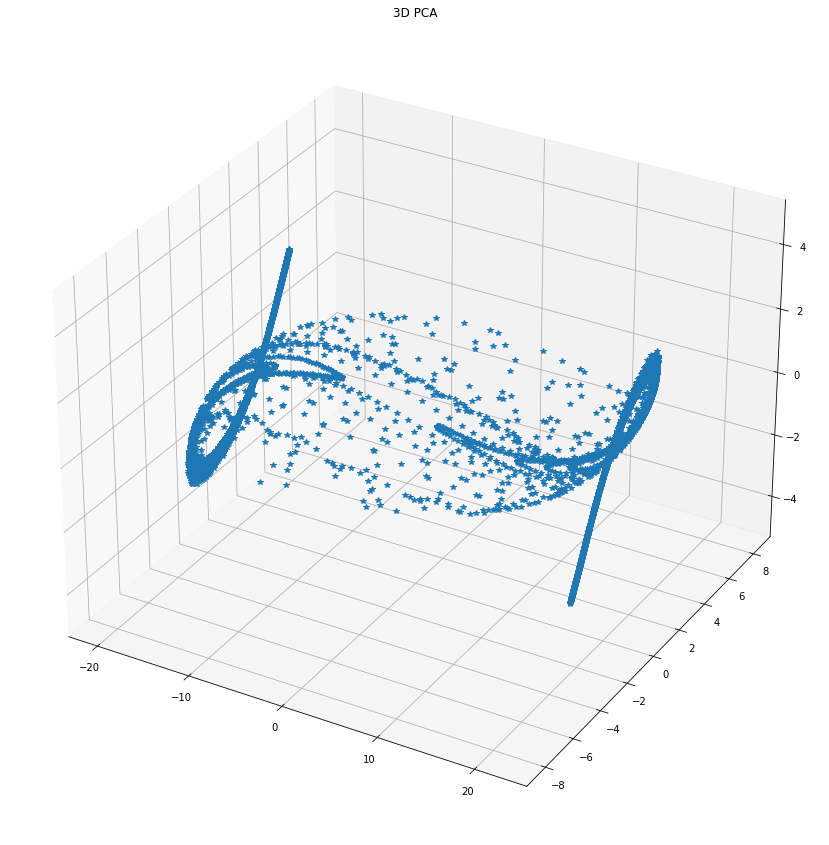
However, try your best and what is really important for your reconstruction is the presence of the two wings of the Lorentz attractor.

As an extra analysis, you should use some already implemented non-linear dimensionality reduction / manifold learning method from scikit-learn and see if the corresponding 2D/3D visualization of the reconstruction is better than the one provided by PCA.

## Project starts from here!

In [1]:
import numpy as np
import pandas as pd

In [2]:
#Loading Lorentz Data
data = open("lorentz.txt").read().split()
data = np.array(data).astype('float64')
data = np.reshape(data, (len(data), -1))
data.shape

(16384, 1)

## Desciption of setting
Reservoir = 500 proves to be most computable efficient for the Lorentz data size <br>
Sparsity = 0.1 Providing some level of looseness to the network for reducing complexity. <br>
Spectral Radius ~ 1 from the lecture notes. <br>
Noise for regularization. <br>
Input and Output dim =1 for simplicity <br>


In [3]:
#Hyper-parameters
num_reservoir= 500 #Number of neurons
sparsity=0.1 #proportion of weight = 0
k_step = 20 #Best computational efficiency with 20 steps
rand_seed=15
radius = 0.95
noise = .0005
input_dim = 1
output_dim = 1

## ESN Model
Wo is assigned with random seeding. <br>
Wi and W_fb is randomly assigned with a uniform distribution in (-1, 1). <br>
Output feedback: 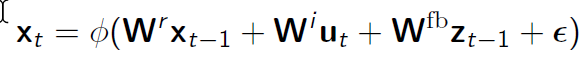  <br>

Reservior Training: 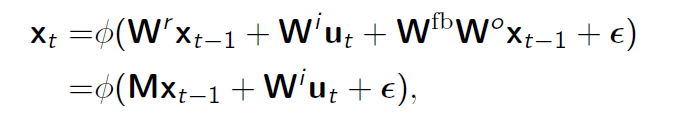 <br>

Testing: 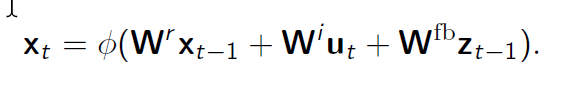 <br>

In [4]:
#INITIALIZATION
random_state = np.random.RandomState(rand_seed)
random_state1 = np.random

#Random weight initialization
W_0 = random_state.rand(num_reservoir, num_reservoir) -0.5 #Adding more randomization by -0.5
W_0[random_state.rand(*W_0.shape) < sparsity] = 0 #Sparse Proportion
#Compute the absolute value of wieght's eigenvalues ie spectral radius 
spectral_radius = np.max(np.abs(np.linalg.eigvals(W_0)))
# Make the weights approach spectral radius
W_0 = W_0 * (radius / spectral_radius)

# Initialize input-to-reservoir weight matrix
W_input = random_state1.uniform(size = (num_reservoir, input_dim), low =-1, high = 1)
#W_input = random_state.rand(num_reservoir, input_dim)
#Initialize feedback matrix
W_fb = random_state1.uniform(size = (num_reservoir, output_dim), low = -1, high = 1)

def compute(inputs, outputs, ksteps):
    # vectorizing to (len,1):
    inputs = np.reshape(inputs, (len(inputs), -1))
    outputs = np.reshape(outputs, (len(outputs), -1))
    #Initialize states as Zeros (we only need the first state to be Zero)
    states = np.zeros((inputs.shape[0], num_reservoir))
    #Compute the next state by feeding last state to current input/output
    for i in range(1, inputs.shape[0]):
        states[i, :] = update_state(states[i-1], inputs[i,:], outputs[i-1,:])
    #Excluding initial states 
    exc_state = min(int(inputs.shape[1] / 10), 100)
    states_ext = np.hstack((states, inputs))
    #Train ESN read-out weights by using pseudoinverse is to compute a best fit (least squares) 
    W_rout = np.dot(np.linalg.pinv(states_ext[exc_state:, :]), (outputs[exc_state:, :])).T
    #print (W_rout)
    
    last_state = states[-1, :]
    last_input = inputs[-1, :]
    last_output = outputs[-1, :]
    
    train_predict = np.dot(states_ext, W_rout.T)
    
    #predict the k-steps ahead by applying the learned weights to k-steps ahead
    #vectorize the forecast horizon
    ksteps = np.reshape(ksteps, (len(ksteps), -1))
    total_steps = ksteps.shape[0]
    ksteps = np.vstack([last_input, ksteps])
    k_states = np.vstack([last_state, np.zeros((total_steps, num_reservoir))])
    k_predictions = np.vstack([last_output, np.zeros((total_steps, output_dim))])
    
    for i in range(total_steps):
            k_states[i + 1, :] = update_state(k_states[i, :], ksteps[i + 1, :], k_predictions[i, :])
            k_predictions[i + 1, :] = np.dot(W_rout, np.concatenate([k_states[i + 1, :], ksteps[i + 1, :]]))
    
    #print ("Success")
    #print (len(k_predictions))
    
    #Returning the k steps ahead prediction and state from the ESN
    return (k_predictions[1:], states )
    
    

def update_state(state, inpt, oupt):
    #feed the target back to the model
    target = (np.dot(W_0, state) + np.dot(W_input, inpt) + np.dot(W_fb, oupt))
    return (np.tanh(target) + noise * (random_state.rand(num_reservoir) - 0.5))

In [5]:
#Random testing
radius/spectral_radius

0.1478873866298695

In [6]:
#Random testing
W_0.shape

(500, 500)

In [7]:
#Random testing
W_fb.shape

(500, 1)

In [8]:
#Random testing
xxx = compute(np.ones(1200), data[0:1200], np.ones(k_step))

In [9]:
#Random testing
xxx[1].shape

(1200, 500)

In [10]:
#Initializing a Dataframe for State attractor
state_arr = pd.DataFrame()

In [11]:
train_len = 15000 # Training the network on 15000 Lorentz rows
k_ahead = 20 # 20 steps ahead prediction
test_len = 1000 # Testing on the bottom 1000 rows
test_matrix = np.zeros(test_len) # Storing test results to compare with original data
for i in range(0, test_len, k_ahead):
    result = compute(np.ones(train_len), data[i:train_len+i], np.ones(k_ahead))
    test_matrix[i:i+k_ahead] = result[0][:, 0]
    lorentz_attr = result[1]
    #print (result[1].shape)
    #Appending the states from ESN to reconstruct Lorentz attractor
    state_arr = state_arr.append(pd.DataFrame(result[1]))

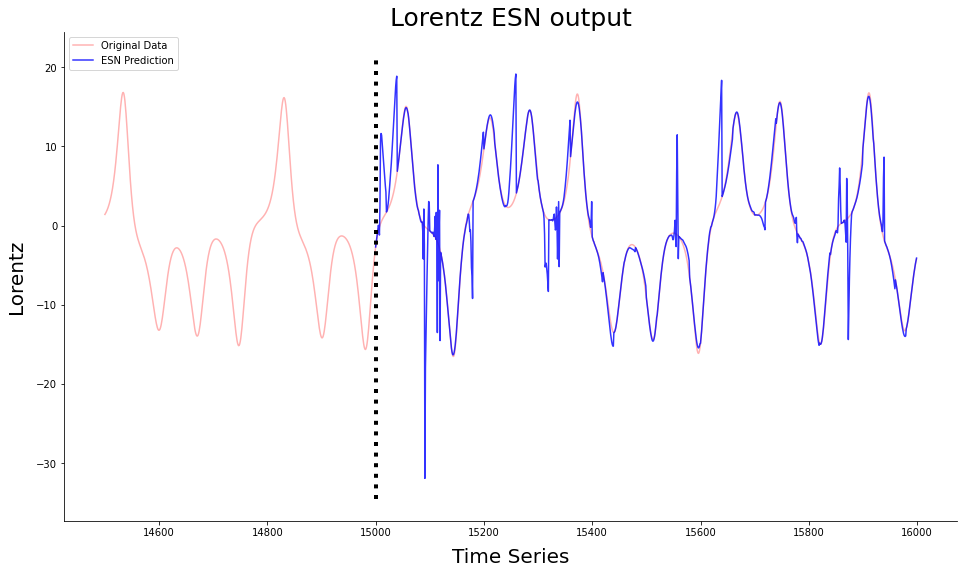

In [12]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns


plt.figure(figsize = (16, 9))
plt.plot(range(14500, train_len + test_len),data[14500:train_len + test_len], 'r', alpha = 0.3)
plt.plot(range(train_len, train_len + test_len), test_matrix, 'b',  alpha=0.8)

lo,hi = plt.ylim()
plt.plot([train_len, train_len],[lo + np.spacing(1), hi-np.spacing(1)], 'k:', linewidth=4)

plt.title('Lorentz ESN output', fontsize = 25)
plt.xlabel('Time Series', fontsize = 20, labelpad = 10)
plt.ylabel('Lorentz', fontsize = 20, labelpad = 10)
plt.legend(['Original Data', 'ESN Prediction'], loc = 'upper left')
sns.despine()

In [13]:
#Random testing
state_arr.shape

(750000, 500)

In [14]:
##Random testing
state_arr.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.042819,0.036770,0.646605,-0.158940,0.125808,0.098677,0.636196,-0.171140,-0.663175,0.470664,...,0.550202,-0.117974,-0.735106,0.165073,-0.656091,-0.693189,-0.478084,0.354981,0.573545,0.276065
2,0.524263,0.166521,0.800275,-0.370765,-0.047066,0.719223,0.702162,-0.502462,-0.861563,0.576826,...,0.522649,-0.063633,-0.655571,-0.237595,-0.144194,-0.730635,-0.328444,0.426725,-0.152500,0.292064
3,0.578996,0.096302,0.796188,-0.342785,-0.039953,0.842974,0.568207,-0.558720,-0.892780,0.452279,...,-0.374552,-0.294066,-0.712524,-0.048761,-0.366095,-0.719182,-0.182692,0.469567,0.248693,0.219691
4,0.620383,0.005886,0.645519,-0.398248,-0.328273,0.796763,0.552535,-0.493584,-0.936322,0.120854,...,-0.400339,-0.467835,-0.855382,-0.005175,-0.284764,-0.759010,0.012119,0.477048,0.239502,0.565627


In [15]:
pca_data = state_arr

In [16]:
pca_data.shape

(750000, 500)

# PCA <br> 

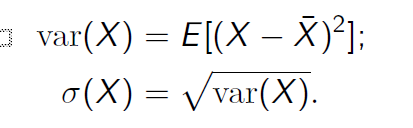 <br>



In [17]:
#Random testing
mean_data = pca_data.mean(axis = 0)
std_data = pca_data.std(axis = 0)

x_scaled = (pca_data-mean_data) / std_data
x_scaled.shape

(750000, 500)

### Covariance (X;Y ) = E[(X-Xo)(Y-Yo)]

In [18]:
#Random testing
print('X: ', x_scaled.shape)
features = x_scaled.T
print('Features: ', features.shape)
cov_matrix = np.cov(features)
print('Covariance: ', cov_matrix.shape)

X:  (750000, 500)
Features:  (500, 750000)
Covariance:  (500, 500)


### Calculating Eigen values and vectors <br>
Eigenvectors are simple unit vectors for direction, and eigenvalues are the magnitude to the eigenvectors.

In [19]:
#calculating eigen vectors and eigen value
eig_value, eig_vector = np.linalg.eig(cov_matrix)
print('Eigenvalues head: ', eig_value[:5])
print('Eigenvalues tail: ', eig_value[-5:])

Eigenvalues head:  [440.04802637  26.56418413  18.54188394   5.65502162   4.60781012]
Eigenvalues tail:  [2.88066982e-08 2.82997694e-08 2.82437863e-08 2.88618400e-08
 2.84659079e-08]


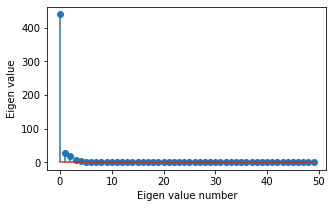

In [20]:
plt.figure(figsize=(5,3))
plt.stem(eig_value[:50], use_line_collection = True)
plt.xlabel('Eigen value number')
plt.ylabel('Eigen value')
plt.show()

In [21]:
#Random testing
x_scaled

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.032253,0.068120,-2.463449,0.083359,-0.020707,-0.051250,-0.024943,0.203506,0.252896,0.014097,...,-0.058437,0.117547,0.113320,0.139567,-0.033549,0.555292,0.355177,-0.146551,-0.662445,-0.123239
1,-0.013617,0.111021,0.003444,-0.081131,0.111341,0.054537,0.653718,0.004236,-0.463261,0.546622,...,0.549580,-0.007283,-0.692224,0.377752,-0.717864,-0.557932,-0.581374,0.327042,0.506697,0.165382
2,0.593870,0.262410,0.589716,-0.300353,-0.070106,0.719797,0.724087,-0.381545,-0.677499,0.666738,...,0.519132,0.050217,-0.605067,-0.203260,-0.183946,-0.618068,-0.288234,0.422759,-0.973307,0.182109
3,0.652503,0.180482,0.574121,-0.271396,-0.062640,0.852464,0.581190,-0.447050,-0.711209,0.525821,...,-0.472347,-0.193608,-0.667478,0.069209,-0.415393,-0.599675,-0.002710,0.479916,-0.155498,0.106445
4,0.696839,0.074987,-0.000702,-0.328795,-0.365259,0.802923,0.564472,-0.371208,-0.758230,0.150835,...,-0.500844,-0.377475,-0.824025,0.132100,-0.330563,-0.663636,0.378918,0.489897,-0.174233,0.468115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1.103407,1.233671,-1.416245,1.118075,-1.070056,1.020613,1.041750,1.367842,1.332734,1.145424,...,-1.163551,1.175602,-0.982443,1.408273,-1.076342,-1.029054,-1.456830,1.147242,-2.024496,-1.168845
14996,1.103614,1.233940,-1.431411,1.118209,-1.070395,1.020626,1.041587,1.367823,1.332747,1.145744,...,-1.163236,1.175603,-0.982693,1.415425,-1.076521,-1.030669,-1.461864,1.148748,-2.062610,-1.168461
14997,1.103595,1.233848,-1.441172,1.118414,-1.070507,1.020938,1.041959,1.368075,1.332878,1.145575,...,-1.163419,1.175826,-0.982738,1.419735,-1.076730,-1.032174,-1.466349,1.149069,-2.087898,-1.168603
14998,1.103398,1.234034,-1.446539,1.118484,-1.070556,1.020774,1.041668,1.367744,1.333007,1.145610,...,-1.163230,1.175562,-0.982646,1.422457,-1.076638,-1.032561,-1.468294,1.149309,-2.102290,-1.168869


In [22]:
#Reshaping for vector projection
eig_vector[:, 0].reshape(num_reservoir, -1).shape


(500, 1)

In [23]:
#Reshaping for vector projection
x_scaled[0].values.reshape((-1, num_reservoir)).shape

(1500, 500)

In [24]:
#Calculating the top 3 eigen vector as they cover most of the variance of the data.
vector_1 = x_scaled.dot(eig_vector.T[0])
vector_2 = x_scaled.dot(eig_vector.T[1])
vector_3 = x_scaled.dot(eig_vector.T[2])
eigen_res = pd.DataFrame(vector_1, columns=['PCA1'])
eigen_res['PCA2'] = vector_2
eigen_res['PCA3'] = vector_3
eigen_res.head()

,PCA1,PCA2,PCA3
0,-1.808581,-1.511748,4.273973
1,-2.720943,-0.320748,-5.268661
2,-1.695304,-0.616168,-8.598832
3,-0.829263,-0.691494,-9.704337
4,-0.573169,-0.383350,-9.729215


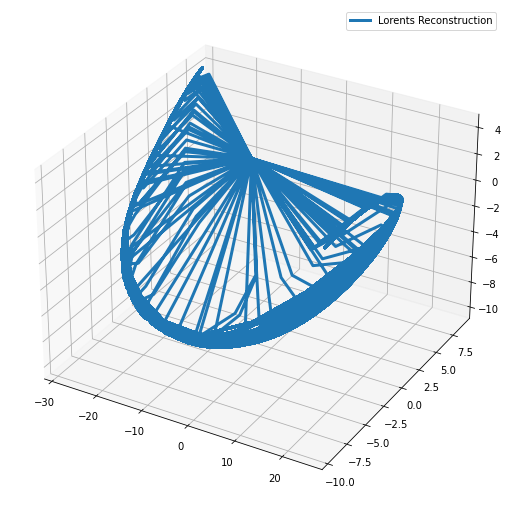

In [25]:
fig = plt.figure(figsize=(20, 20))
plt.subplot(211, projection="3d")
plt.plot(eigen_res['PCA1'],eigen_res['PCA2'], eigen_res['PCA3'], lw=3, label="Lorents Reconstruction")
plt.legend(); plt.show()

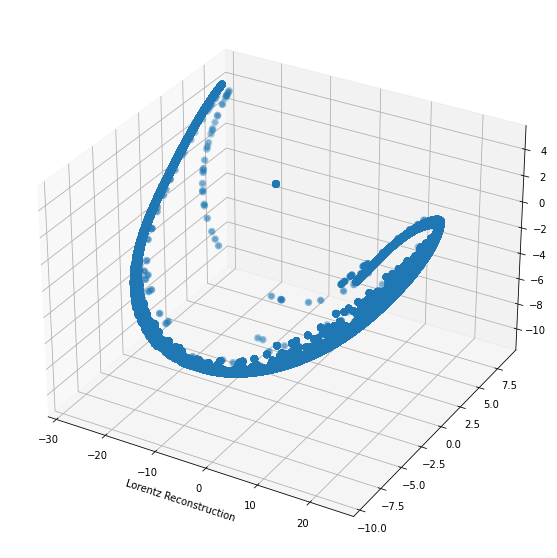

In [26]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection='3d', label = "Lorentz Reconstruction")
ax.set_xlabel("Lorentz Reconstruction")
ax.scatter3D(eigen_res['PCA1'],eigen_res['PCA2'], eigen_res['PCA3'], lw=3, label="Lorentz Reconstruction")


# Repeating the Task 1 for 2sin Data 

In [27]:
#Hyper-parameters
num_reservoir= 200 #Number of neurons
sparsity=0.1 #proportion of weight = 0
#k_step = 20
rand_seed=15
radius = 0.95
noise = .0005
input_dim = 1
output_dim = 1



In [28]:
#INITIALIZATION
random_state = np.random.RandomState(rand_seed)
random_state1 = np.random

#Random weight initialization
W_0 = random_state.rand(num_reservoir, num_reservoir) -0.5 #Adding more randomization by -0.5
W_0[random_state.rand(*W_0.shape) < sparsity] = 0 #Sparse Proportion
#Compute the absolute value of wieght's eigenvalues ie spectral radius 
spectral_radius = np.max(np.abs(np.linalg.eigvals(W_0)))
# Make the weights approach spectral radius
W_0 = W_0 * (radius / spectral_radius)

# Initialize input-to-reservoir weight matrix
W_input = random_state1.uniform(size = (num_reservoir, input_dim), low =-1, high = 1)
#W_input = random_state.rand(num_reservoir, input_dim)
#Initialize feedback matrix
W_fb = random_state1.uniform(size = (num_reservoir, output_dim), low = -1, high = 1)

def compute2(inputs, outputs, ksteps):
    # vectorizing to (len,1):
    inputs = np.reshape(inputs, (len(inputs), -1))
    outputs = np.reshape(outputs, (len(outputs), -1))
    #Initialize states as Zeros (we only need the first state to be Zero)
    states = np.zeros((inputs.shape[0], num_reservoir))
    #Compute the next state by feeding last state to current input/output
    for i in range(1, inputs.shape[0]):
        states[i, :] = update_state(states[i-1], inputs[i,:], outputs[i-1,:])
    #Excluding initial states 
    exc_state = min(int(inputs.shape[1] / 10), 100)
    states_ext = np.hstack((states, inputs))
    #Train ESN read-out weights by using pseudoinverse is to compute a best fit (least squares) 
    W_rout = np.dot(np.linalg.pinv(states_ext[exc_state:, :]), (outputs[exc_state:, :])).T
    #print (W_out)
    
    last_state = states[-1, :]
    last_input = inputs[-1, :]
    last_output = outputs[-1, :]
    
    train_predict = np.dot(states_ext, W_rout.T)
    
    #predict the k-steps ahead by applying the learned weights to k-steps ahead
    #vectorize the forecast horizon
    ksteps = np.reshape(ksteps, (len(ksteps), -1))
    total_steps = ksteps.shape[0]
    ksteps = np.vstack([last_input, ksteps])
    k_states = np.vstack([last_state, np.zeros((total_steps, num_reservoir))])
    k_predictions = np.vstack([last_output, np.zeros((total_steps, output_dim))])
    
    for i in range(total_steps):
            k_states[i + 1, :] = update_state(k_states[i, :], ksteps[i + 1, :], k_predictions[i, :])
            k_predictions[i + 1, :] = np.dot(W_rout, np.concatenate([k_states[i + 1, :], ksteps[i + 1, :]]))
    
    #print ("Success")
    #print (len(k_predictions))
    return (k_predictions[1:], states )
    
    

def update_state(state, inpt, oupt):
    #feed the target back 
    target = (np.dot(W_0, state) + np.dot(W_input, inpt) + np.dot(W_fb, oupt))
    return (np.tanh(target) + noise * (random_state.rand(num_reservoir) - 0.5))

In [29]:
data_2 = open("2sin.txt").read().split()
data_2 = np.array(data_2).astype('float64')
data_2 = np.reshape(data_2, (len(data_2), -1))
data_2.shape

train_len_2= 1800 #
k_ahead_2= 10 #
test_len_2= 200 #
test_matrix_2= np.zeros(test_len_2) #
for i in range(0, test_len_2, k_ahead_2):
    result_2 = compute2(np.ones(train_len_2), data[i:train_len_2+i], np.ones(k_ahead_2))
    test_matrix_2[i:i+k_ahead_2] = result_2[0][:, 0]
    #lorentz_attr = result_[1]
    #print (result[1].shape)
    #state_arr = state_arr.append(pd.DataFrame(result[1]))

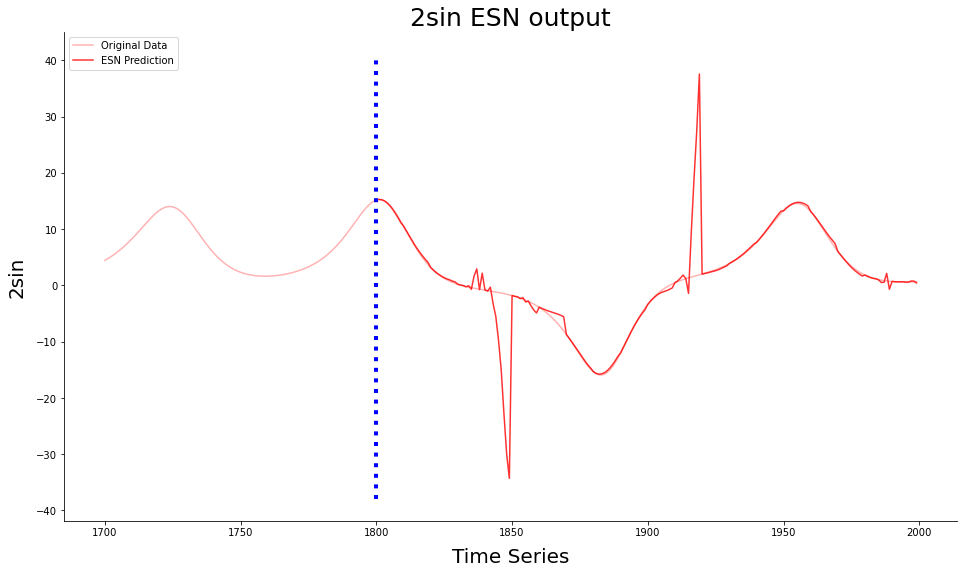

In [30]:
plt.figure(figsize=(16, 9))
plt.plot(range(1700,train_len_2+test_len_2),data[1700:train_len_2+test_len_2],'r', alpha=0.3)
plt.plot(range(train_len_2, train_len_2 + test_len_2), test_matrix_2,'r',  alpha=0.8)

lo,hi = plt.ylim()
plt.plot([train_len_2, train_len_2],[lo+np.spacing(1),hi-np.spacing(1)],'b:', linewidth=4)

plt.title('2sin ESN output', fontsize=25)
plt.xlabel('Time Series', fontsize=20,labelpad=10)
plt.ylabel('2sin', fontsize=20,labelpad=10)
plt.legend(['Original Data', 'ESN Prediction'], loc='upper left')
sns.despine()